# 隠れマルコフモデル（HMM）

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## データ生成

表裏の出る確率が異なる2つのコインがあり、途中でコインが入れ替わりうる状況でサンプルされた系列

In [2]:
# 系列数
N = 100

# 隠れ状態は0 or 1 (どちらのコインか)
hidden_states = [0, 1]

# 観測は0 or 1 (コインの表裏)
observations = [0, 1]
# 隠れ状態 i のときに観測 j を得る確率
observation_proba = [[0.8, 0.2],
                                 [0.2, 0.8]]

# 隠れ状態の遷移確率 (コインの入れ替わる確率)
transition_proba = [[0.9, 0.1],
                             [0.1, 0.9]]

# 初期隠れ状態
initial_proba = [0.5, 0.5]
hidden_state = np.random.choice(hidden_states, p=initial_proba)

seq = []
seq_hidden = []
for i in range(N):
    seq_hidden.append(hidden_state)
    seq.append(np.random.choice(observations, p=observation_proba[hidden_state]))
    hidden_state = np.random.choice(hidden_states, p=transition_proba[hidden_state])
seq = np.array(seq)
true_seq_hidden = np.array(seq_hidden)

(-1, 100)

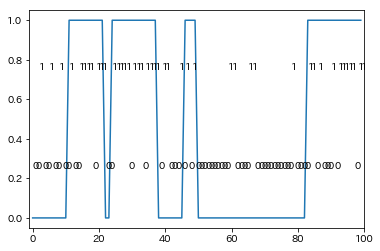

In [3]:
# 隠れ状態
plt.plot(true_seq_hidden)
# 観測
for i in range(N):
    plt.annotate(str(seq[i]), (i, 0.5 * seq[i] + 0.25))
plt.xlim(-1, len(seq))

### モデル

状態遷移確率、初期状態確率、観測確率は以下である。($\boldsymbol{z},\boldsymbol{x}$は1-of-K表現)
\begin{eqnarray}
p(\boldsymbol{z}_{n} | \boldsymbol{z}_{n-1}; A) &=& \prod_{i=1}^{K} \prod_{j=1}^{K} A_{ij}^{z_{(n-1)i} z_{nj}} \\
p(\boldsymbol{z}_{1} ; \boldsymbol{\pi}) &=& \prod_{i=1}^{K} \pi_{i}^{z_{1i}} \\
p(\boldsymbol{x}_{n} | \boldsymbol{z}_{n}; C) &=& \prod_{i=1}^{K} \prod_{j=1}^{D} C_{ij}^{z_{ni} x_{nj}}
\end{eqnarray}

## 学習

パラメータを$\boldsymbol{\theta} = [A, C, \boldsymbol{\pi}]$としEMアルゴリズムによってパラメータを推定する。観測データ$X = [\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, .., \boldsymbol{x}_{N}]$, 潜在変数$Z = [\boldsymbol{z}_{1}, \boldsymbol{z}_{2}, .., \boldsymbol{z}_{N}]$に対して対数尤度関数は以下のようになる。

\begin{eqnarray}
\log{p(X, Z | \boldsymbol{\theta})} &=& \log{[p(\boldsymbol{z}_{1}) \prod_{n=2}^{N} p(\boldsymbol{z}_{n} | \boldsymbol{z}_{n-1}) \prod_{n=1}^{N} p(\boldsymbol{x}_{n} | \boldsymbol{z}_{n})]} \\
&=& \log{p(\boldsymbol{z}_{1}; \boldsymbol{\pi})} + \sum_{n=2}^{N} \log{p(\boldsymbol{z}_{n} | \boldsymbol{z}_{n-1}; A)} + \sum_{n=1}^{N} \log{p(\boldsymbol{x}_{n} | \boldsymbol{z}_{n}; C)}
\end{eqnarray}

EMアルゴリズムでは
1. パラメータを初期化する。
2. 現在のパラメータでの事後分布$p(Z| X, \boldsymbol{\theta}^{old})$を計算する。(E step)
3. その分布における期待対数尤度関数$\mathbb{E}_{Z | \boldsymbol{\theta}^{old}} [\log{p(X, Z | \boldsymbol{\theta})}]$を最大化するパラメータ$\boldsymbol{\theta}^{new}$を計算する。(M step)
4. 収束すれば終了し、そうでなければ2へ戻る。

## Eステップ

### 前向きの推定（フィルタリング）

フィルタリングでは、$\alpha(\boldsymbol{z}_{n})$という量を計算する。これは

\begin{eqnarray}
\alpha(\boldsymbol{z}_{n}) = p(\boldsymbol{x}_{1}:\boldsymbol{x}_{n}, \boldsymbol{z}_{n}) &=& p(\boldsymbol{x}_{n} | \boldsymbol{z}_{n}) p(\boldsymbol{x}_{1}:\boldsymbol{x}_{n-1}, \boldsymbol{z}_{n}) \\
&=& p(\boldsymbol{x}_{n} | \boldsymbol{z}_{n}) \sum_{\boldsymbol{z}_{n-1}} p(\boldsymbol{z}_{n} | \boldsymbol{z}_{n-1})p(\boldsymbol{x}_{1}:\boldsymbol{x}_{n-1}, \boldsymbol{z}_{n-1}) \\
&=& p(\boldsymbol{x}_{n} | \boldsymbol{z}_{n}) \sum_{\boldsymbol{z}_{n-1}} p(\boldsymbol{z}_{n} | \boldsymbol{z}_{n-1}) \alpha(\boldsymbol{z}_{n-1})
\end{eqnarray} 

という再帰的な式で書ける。ただし、$\alpha(\boldsymbol{z}_{1}) = p(\boldsymbol{x}_{1} | \boldsymbol{z}_{1}) p(\boldsymbol{z}_{1})$

### 後ろ向きの推定（スムージング）

スムージングでは、$\beta(\boldsymbol{z}_{n})$という量を計算する。これも

\begin{eqnarray}
\beta(\boldsymbol{z}_{n}) = p(\boldsymbol{x}_{n+1}:\boldsymbol{x}_{N} | \boldsymbol{z}_{n}) &=& \sum_{\boldsymbol{z}_{n+1}} p(\boldsymbol{x}_{n+2}:\boldsymbol{x}_{N}| \boldsymbol{z}_{n+1}) p(\boldsymbol{x}_{n+1}| \boldsymbol{z}_{n+1}) p(\boldsymbol{z}_{n+1}| \boldsymbol{z}_{n}) \\
&=& \sum_{\boldsymbol{z}_{n+1}}\beta(\boldsymbol{z}_{n+1}) p(\boldsymbol{x}_{n+1}| \boldsymbol{z}_{n+1}) p(\boldsymbol{z}_{n+1}| \boldsymbol{z}_{n}) 
\end{eqnarray}

という再帰的な式で書ける。ただし、$\beta(\boldsymbol{z}_{N}) = 1$

### 事後分布

事後分布は、以下のように求められる。

$\gamma(\boldsymbol{z}_{n}) = p(\boldsymbol{z}_{n} | \boldsymbol{x}_{1}:\boldsymbol{x}_{N}) \propto \alpha(\boldsymbol{z}_{n}) \beta(\boldsymbol{z}_{n})$

$\xi(\boldsymbol{z}_{n-1}, \boldsymbol{z}_{n}) = p(\boldsymbol{z}_{n-1}, \boldsymbol{z}_{n} | \boldsymbol{x}_{1}:\boldsymbol{x}_{N}) \propto \alpha(\boldsymbol{z}_{n-1}) p(\boldsymbol{z}_{n} | \boldsymbol{z}_{n-1}) p(\boldsymbol{x}_{n} | \boldsymbol{z}_{n}) \beta(\boldsymbol{z}_{n})$

## Mステップ

ステップ3では、$z$が離散値(0, 1)であることや$\boldsymbol{\pi}, A_{i}, C_{i}$が確率値であることを考慮して最大化を行う。

$\gamma_{nj} = \gamma(z_{nj} = 1), \xi_{nij} = \xi(z_{n-1i} = 1, z_{nj} = 1)$とすると、計算される新しいパラメータは以下のようになる。

\begin{eqnarray}
\pi_{j} &=& \frac{\gamma_{1j}}{\sum_{k=1}^{K} \gamma_{1k}} \\
A_{ij} &=& \frac{\sum_{n=2}^{N} \xi_{nij}}{\sum_{k=1}^{K} \sum_{n=2}^{N} \xi_{nik}} \\
C_{ij} &=& \frac{\sum_{n=1}^{N} \gamma_{ni} x_{nj}}{\sum_{n=1}^{N} \gamma_{ni}} \\
\end{eqnarray}

In [4]:
n_hidden = 2

# パラメータ初期化
pi = np.array([0.5, 0.5])
A = np.array([[0.8, 0.2],
                    [0.2, 0.8]])
C = np.array([[0.7, 0.3],
                    [0.3, 0.7]])

params = [pi, A, C]

def expectation(seq, params):
    pi, A, C = params
    # likelihood = p(x | z)
    likelihood = C[seq]
    
    # forward
    f = likelihood[0] * pi
    constant = [f.sum()]
    alpha = [f / f.sum()]
    for like in likelihood[1:]:
        f = like * np.dot(alpha[-1], A)
        constant.append(f.sum())
        alpha.append(f / f.sum())
    alpha = np.asarray(alpha)
    
    # backward
    beta = np.zeros((N, n_hidden))
    beta[-1] = [1, 1]
    for n in reversed(range(N-1)):
        beta[n] = np.dot(A, (likelihood[n+1] * beta[n+1])) / constant[n+1]
    
    # posterior
    gamma = alpha * beta
    xi = alpha[:-1, :, None] * A * likelihood[1:, None, :] * beta[1:, None, :]
    return gamma, xi

def maximization(seq, gamma, xi):
    pi = gamma[0] / np.sum(gamma[0])
    A = np.sum(xi, axis=0) / np.sum(xi, axis=(0, 2))
    x = gamma[:, :, None] * (np.eye(n_hidden)[seq])[:, None, :]
    C = np.sum(x, axis=0) / np.sum(gamma, axis=0)[:, None]
    return [pi, A, C]

In [5]:
iter_max = 10000

prev_params = np.hstack([p.ravel() for p in params])
for i in range(iter_max):
    gamma, xi = expectation(seq, params)
    params = maximization(seq, gamma, xi)
    
    new_params = np.hstack([p.ravel() for p in params])
    if np.allclose(prev_params - new_params, 0):
        break
    else:
        prev_params = new_params

## 学習結果

In [6]:
posterior, _ = expectation(seq, params)

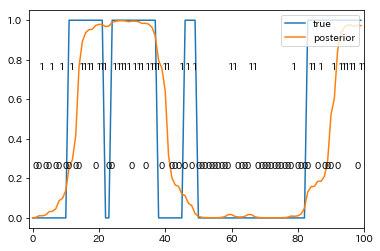

In [7]:
# 隠れ状態
plt.plot(true_seq_hidden, label='true')
plt.plot(posterior[:, 1], label='posterior')
# 観測
for i in range(N):
    plt.annotate(str(seq[i]), (i, 0.5 * seq[i] + 0.25))
plt.xlim(-1, len(seq))
plt.legend(loc='upper right')